In [1]:
from model import FFNet
from learning import Learn, Selector
from dataset import Dummy

from torch.optim import Adam
from torch.nn import MSELoss

<class 'dataset.Dummy'> dataset created...
epoch: 0 of 100, train loss: 9260.837567729335, val loss: 1153.9535319010417, lr: 0.1
epoch: 10 of 100, train loss: 1130.393049670804, val loss: 2071.813680013021, lr: 0.1
epoch: 20 of 100, train loss: 1004.3423048450101, val loss: 757.13037109375, lr: 0.1
epoch: 30 of 100, train loss: 1172.0454780824723, val loss: 1550.6270751953125, lr: 0.1
epoch: 40 of 100, train loss: 656.9399561728201, val loss: 439.9614562988281, lr: 0.010000000000000002
epoch: 50 of 100, train loss: 746.0640711630545, val loss: 478.69106038411456, lr: 0.010000000000000002
epoch: 60 of 100, train loss: 534.6013478925152, val loss: 571.9814860026041, lr: 0.0010000000000000002
epoch: 70 of 100, train loss: 503.2263616746472, val loss: 500.75169881184894, lr: 0.00010000000000000003
epoch: 80 of 100, train loss: 538.9856301584551, val loss: 514.4039306640625, lr: 1.0000000000000004e-05
epoch: 90 of 100, train loss: 552.7958068847656, val loss: 557.9826253255209, lr: 1.000000

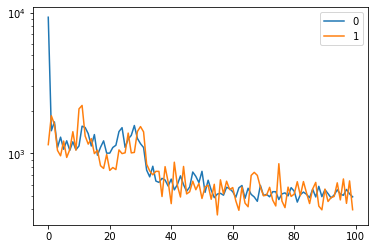

learning time: 0:01:10.830975


In [2]:
opt_params = {'lr': 0.1}
model_params = {'D_in': 128, 
                'H': 512, 
                'D_out': 1, 
                'model_name': 'funnel'}
ds_params = {'make': 'make_regression',
             'make_params': {'n_samples': 10000,
                             'n_features': 128}}
crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.1,.8)}

l = Learn(Dummy, FFNet, Selector, Optimizer=Adam, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, opt_params=opt_params,
          crit_params=crit_params, sample_params=sample_params,
          save_model=False, load_model=False, load_embed=False, adapt=False,
          batch_size=256, epochs=100)